# Exercise for Lecture 13: Data Exploration
  
Having learned the basics of Python and data exploration, you will apply visualization techniques and PCA to some SYSLAB data.

This notebook is not a tutorial, and will therefore only give you hints at how to solve the exercises. The results of this notebook will be part of your hand-in for this part of the course.

<font color='green'>
Don't really care much for the custom CSS, so I disabled that cell
</font> 

In [1]:
#from IPython.core.display import HTML
#css_file = './31380.css'
#HTML(open(css_file, "r").read())

In [3]:
# You will be using (at least) the following packages for this exercise
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Exercise 1 - Data Manipulation

1. Download the data set from [Inside DTU](www.inside.dtu.dk), and unzip it. With the terminal look at the headings of the files, what do you think these files contain?
2. Use the bash commands you learned last lecture to join all the meteo files in one csv, all the pv files in another csv and the gaia files in one csv.
    * *Hint: remember to only have one header when you're concatenating the files.*
3. Import the 3 resulting data files using the pandas library [read_csv](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html), e.g.:
```python
    pv_data = pd.read_csv('pv.csv')
```
    * *Hint: Note that you can choose which columns you want to import using the option `usecols=['*variable_1*','*variable_2*']`*
    * From the meteo file you will need timestamp, temperature, wind speed, wind direction, and the three insolation columns.
    * From the PV files you will need timestamp and the AC power output *Pac_0[kW]*.
    * From the wind turbine you will need the timestamp, and the power output *P[kW]*.

<font color='green'>
First we need to import the correct columns into our dataframe. Since I want to combine all the relevant data columns into a single dataframe later, I am not using a Series to contain my data.
</font> 

In [8]:
meteo_data = pd.read_csv('data/meteo.csv', usecols=['TIMESTAMP','TEMPERATURE_temp1[degC]','WINDSPEED_wspd1[m/s]','WINDDIR_wdir1[deg]','INSOLATION_irrad1[kW/m2]','INSOLATION_irrad2[kW/m2]','INSOLATION_irrad3[kW/m2]'])
pv_data = pd.read_csv('data/pv.csv', usecols=['TIMESTAMP','Pac_0[kW]'])
gaia_data = pd.read_csv('data/gaia.csv', usecols=['TIMESTAMP','P[kW]'])
print("pv: {}".format(pv_data.columns.values))
print("gaia: {}".format(gaia_data.columns.values))
print("meteo: {}".format(meteo_data.columns.values))

pv: ['TIMESTAMP' 'Pac_0[kW]']
gaia: ['TIMESTAMP' 'P[kW]']
meteo: ['TIMESTAMP' 'TEMPERATURE_temp1[degC]' 'WINDSPEED_wspd1[m/s]'
 'WINDDIR_wdir1[deg]' 'INSOLATION_irrad1[kW/m2]' 'INSOLATION_irrad2[kW/m2]'
 'INSOLATION_irrad3[kW/m2]']


## Exercise 2 - Plotting/Cleaning

Create a set of time series plots of the different variables. Does the data look ok to you? what can you do to fix it? when do you think you can interpolate and when do you throw out data objects? What's up with solar power?

* *Hint: pandas has the built in functions [interpolate](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.interpolate.html) and [dropna](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.dropna.html).*

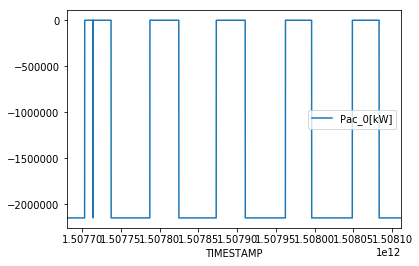

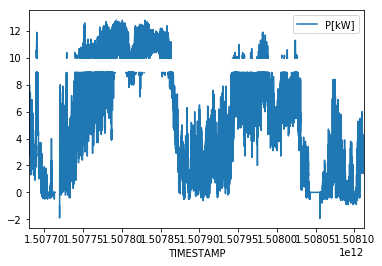

In [9]:
### Sample plots to get a feel for our data
pv_data.plot(x='TIMESTAMP', y='Pac_0[kW]');
gaia_data.plot(x='TIMESTAMP', y='P[kW]');

In [10]:
# Data cleanup, removing N/A
pv_data = pv_data.dropna()
meteo_data = meteo_data.dropna()
gaia_data = gaia_data.dropna()

## Exercise 3 - Data exploration

Now that you have some squeaky clean data, merge your data files into a single DataFrame.

A few hints before you continue:
* *The timestamps are in Unix/epoch time with millisecond resolution. When first exploring data, I recommend converting it to human-readable time with code like the following (this is a bit advanced code which uses lambda functions, think about what it does, but don't worry too much about it!):*

```python
pv_data['TIMESTAMP'] = pv_data['TIMESTAMP'].apply(lambda x: pd.to_datetime(round(x/1000),unit='s'))
```

    

* *You can merge two DataFrames using the pandas [merge](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) function. What is the difference between inner and outer merge?*
* *You might need to check if there's new entries containing *nan* values, e.g.:*
```python
pv_data.isnull().sum()
```

<font color='green'>
Now that we are combining our data, we can contain it in a Series. From the lambda function we can see that the timestamp is in miliseconds.
</font> 

In [21]:
data = pd.Series({})
data['clean'] = pv_data.merge(gaia_data, left_on='TIMESTAMP', right_on='TIMESTAMP', how='inner')
data['clean'] = data['clean'].merge(meteo_data, left_on='TIMESTAMP', right_on='TIMESTAMP', how='inner')
data['numerical'] = data['clean'].select_dtypes(exclude=['datetime64[ns]'])
data['clean']['TIMESTAMP'] = pd.to_datetime(data['clean']['TIMESTAMP'], unit='ms')
data['clean'].columns.values

array(['TIMESTAMP', 'Pac_0[kW]', 'P[kW]', 'TEMPERATURE_temp1[degC]',
       'WINDSPEED_wspd1[m/s]', 'WINDDIR_wdir1[deg]',
       'INSOLATION_irrad1[kW/m2]', 'INSOLATION_irrad2[kW/m2]',
       'INSOLATION_irrad3[kW/m2]'], dtype=object)

Create some scatter plots, e.g. wind power vs. wind speed and wind direction, solar power vs. the different irradiation columns and temperature. Which relationships do you see?

* *Hint: you can use pandas built-in [plot](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.scatter.html) functions.*

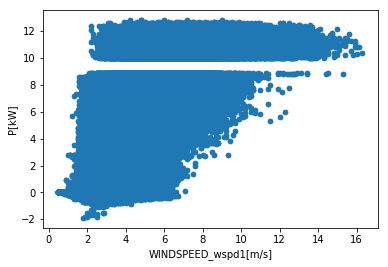

In [9]:
# Scatter plots
data['clean'].plot.scatter(x='WINDSPEED_wspd1[m/s]', y='P[kW]');

It is a bit hard to conclude something on the windspeed vs. wind power, isn't it? How close do you think the meteorological mast is to the wind turbine? Going back to the original Gaia dataset, do you think the wind measurement there will give you better results? Try it out!



In [14]:
gaia_data_raw = pd.read_csv('data/gaia.csv', usecols=['TIMESTAMP','P[kW]','WINDSPEED[m/s]'])
gaia_data_raw = gaia_data_raw.dropna()

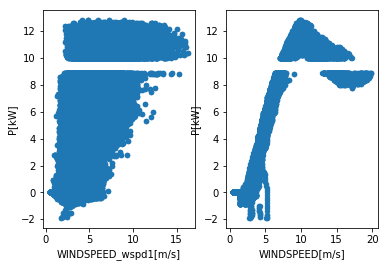

In [15]:
### Compare plot for wind power as a function of wind speed.
fig, axes = plt.subplots(nrows=1, ncols=2)
data['clean'].plot.scatter(x='WINDSPEED_wspd1[m/s]', y='P[kW]', ax=axes[0]);
gaia_data_raw.plot.scatter(x='WINDSPEED[m/s]', y='P[kW]', ax=axes[1]);

<font color='green'>
Here we can see that the windspeed data from the turbine, gives a better correlation.
</font>

## Exercise 4 - PCA

In this exercise we will apply the concept of PCA to the data set from above. 

Using the library sci-kit learn, create a [PCA object](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html), starting with one the size of your input variable DataFrame. Find out how much of the variance is explained for each principal component.

* *Hint: Look at the PCA documentation*
* *Hint: Remember to standardize your data before you work on it! *

<font color='green'>
Before we do a PCA we can calculate eigenvalues and eigenvectors, from which we can calculate the percentage of total variance explained as a function of n components.
</font> 

In [16]:
### Standardize and process eigen* data
from sklearn.preprocessing import StandardScaler

data['X_std'] = StandardScaler().fit_transform(data['numerical'].values)
data['covariance'] = np.cov(data['X_std'].T)
data['eigenvalues'], data['eigenvectors'] = np.linalg.eig(data['covariance'])
data['eigenvalues_variance_explained'] = [(i/data['eigenvalues'].sum())*100 for i in sorted(data['eigenvalues'], reverse=True)]

Plot the variance explained of each PC and the cummulative sum of the ratio of explained variance. What do you think you need to consider, in order to choose how many principal components you want to reduce your data to?

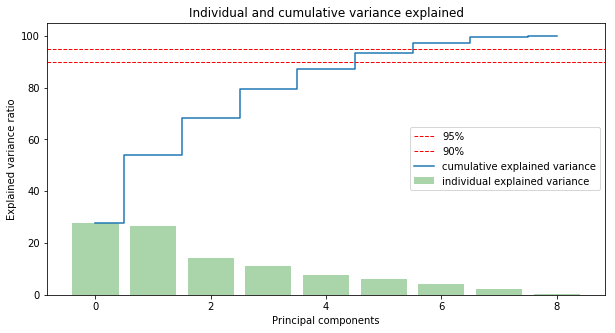

In [17]:
### Create graphs for variance explained
max_components = data['eigenvalues'].shape[0]
plt.figure(figsize=(10, 5))
plt.bar(range(max_components), data['eigenvalues_variance_explained'], alpha=0.3333, align='center', label='individual explained variance', color = 'g')
plt.axhline(y=95, linewidth=1, color='r', linestyle='dashed', label="95%")
plt.axhline(y=90, linewidth=1, color='r', linestyle='dashed', label="90%")
plt.step(range(max_components), np.cumsum(data['eigenvalues_variance_explained']), where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.title('Individual and cumulative variance explained')
plt.show()

<font color='green'>
From the graph we can see that 6 principle components are needed to explain 90-95% of the variance.
</font> 

In [21]:
from sklearn.decomposition import PCA

pca = PCA(n_components=6)
data['PCA'] = pca.fit_transform(data['X_std'])
pd.DataFrame(pca.components_)

,0,1,2,3,4,5,6,7,8
0,0.305151,0.423076,-0.368054,0.351143,-0.317565,-0.351615,0.398147,-0.055087,0.288250
1,-0.239804,0.269658,0.402862,-0.082368,0.400797,0.218161,0.477898,-0.043830,0.512012
2,-0.577327,0.108712,-0.320620,-0.622375,-0.316611,-0.212602,0.080580,0.064082,0.093199
3,0.029398,0.039445,0.017298,0.069943,0.002173,0.031445,0.040232,0.994606,0.023126
4,-0.143029,0.016835,0.206050,0.070907,0.435445,-0.848013,-0.094393,0.027357,-0.115662
5,0.302844,-0.747813,-0.125948,-0.214470,0.046764,-0.174014,0.182015,0.025085,0.470079


Now make a scatter plot of the first loading vector of the first principal component vs. the loading vector of the second principal component. Which features seem to be more correlated?

* *Hint: Once you've fitted your PCA, the loading vectors are stored in PCA.components_ as a numpy array.*

You can label each point with the following piece of code, substituting the *data* and *pca.components_* with your own variable names:

```python
fig,ax = plt.subplots()
plt.scatter(pca.components_[0],pca.components_[1])
for i, txt in enumerate(data.columns):
    ax.annotate(txt, (pca.components_[0][i],pca.components_[1][i]),xytext=(10,-5), textcoords='offset points', fontsize=8)
```

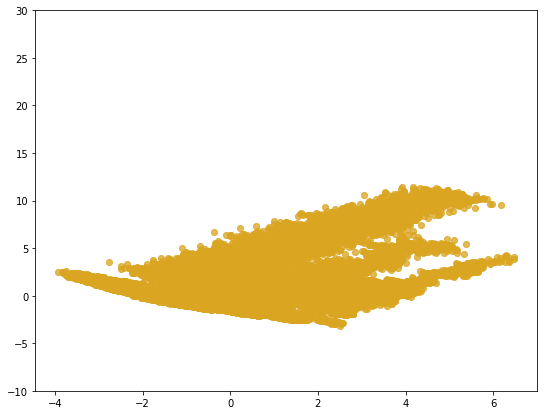

In [22]:
# An even fancier plot
plt.figure(figsize = (9,7))
plt.scatter(data['PCA'][:,0],data['PCA'][:,1], c='goldenrod',alpha=0.5)
plt.ylim(-10,30)
plt.show()

## Exercise 5: K-means clustering

For this exercise we will load the weather data provided by Tue (and presented during the lecture).

You will probably need to install the *tables* package using:

```
pip install tables
```

In [ ]:
with pd.HDFStore('../ex13_data/mysolarstore.h5') as store:
    smean = store['wmean'] # Mean solar irradiation (NxM)
    sstd = store['wstd'] # Standard deviation of solar irradiation (NxM)
    lat = store['lat'] # Latitudes (NxM)
    lon = store['lon'] # Longitudes (NxM)
    spcas = store['pcas'] # PCA components (KxNxM)
    spcaproj = store['pcaproj'] # PCA Projections (KxT)
    svar = store['variance_explained'] # Variance explained (K)
    svar_ratio = store['variance_explained_ratio'] # Variance explained relative to total variance (K)

First, you will perform K-means clustering on the projection of the 1st principal component vs. the 2nd principal component. So slice *pcaproj* in order to get the right data and take a quick peak at the [sci-kit learn documentation](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


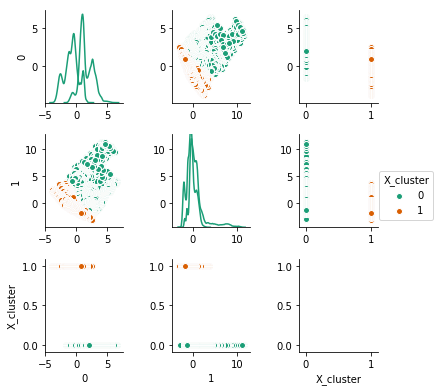

In [23]:
from sklearn.cluster import KMeans
import seaborn as sns

kmeans = KMeans(n_clusters=2)
X_clustered  = kmeans.fit_predict(data['PCA'])

df = pd.DataFrame(data['PCA'])
df = df[[0,1]]
df['X_cluster'] = X_clustered
sns.pairplot(df, hue='X_cluster', palette= 'Dark2', diag_kind='kde',size=1.85);


In order to plot the clustering use the following piece of code, which assumes that *cluster_pred* is the outcome of your k-means cluster prediction on the data. What do you think the *random_state* variable defines?

In [ ]:
X_clustered.shape

In [ ]:
random_state = 100
plt.figure()
plt.scatter(spcaproj[0],spcaproj[1], c=X_clustered)

Now try applying k-means clustering to the 1st principal component vs. the 3rd principal component. What goes wrong?

In [ ]:
# k-means for 1st vs 3rd pc goes here

Now let's try the same with wind data. Use k-means to cluster the 1st principal component vs. the 2nd principal component. Is it meaningful? try selecting a few different start conditions and numbers of clusters.

In [ ]:
with pd.HDFStore('mywindstore.h5') as store:
    wmean = store['wmean']
    wstd = store['wstd']
    lat = store['lat']
    lon = store['lon']
    wpcas = store['pcas']
    wpcaproj = store['pcaproj']
    wvar = store['variance_explained']
    wvar_ratio = store['variance_explained_ratio']

In [ ]:
# your clustering goes here